In [1]:
#install.packages("lmerTest")
library(DHARMa)
library(lindia)
library(tidyverse)
library(caret)
library(leaps)
library(MASS)
library(modEvA)
library(dplyr)
library(lme4) #random effect
library(broom)
library(ggpubr) 
library(rstatix)
library(WRS2) #robust ancova
library(lmerTest) #like lmer but with p-value

This is DHARMa 0.3.3.0. For overview type '?DHARMa'. For recent changes, type news(package = 'DHARMa') Note: Syntax of plotResiduals has changed in 0.3.0, see ?plotResiduals for details

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.0.6     v dplyr   1.0.3
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:purrr':

    lift



Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select


Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':



install.packages("WRS", repos="http://R-Forge.R-project.org", type="source")
library(WRS)

## Download data

In [3]:
path_ = 'G:/VPHI/Welfare/2- Research Projects/OFHE2.OriginsE2/DataOutput/TrackingSystem/chapter0_final_/Cleaning/Raw&Cleaned'
#path_ = 'C:/Users/camil/Desktop'
#jpeg(file.path(path_, 'diagnostic_plot_.jpg'))
df = read.csv(file.path(path_, 'df4DifferenceModelling.csv'), header = TRUE, sep = ";")
#df = read.csv(file.path(path_, 'df4DifferenceModelling_4lowerDF.csv'), header = TRUE, sep = ";")
#df = read.csv(file.path(path_, 'df4DifferenceModelling_mixedHenID.csv'), header = TRUE, sep = ";")
#li_var_cont = c('ID0','ID1','ID2','ID3','ID4','ID5','ID6','ID7')
df$PenID = as.factor(df$PenID)
df$tracking_system = as.factor(df$tracking_system)
df$Trackingsystem_Zone = as.factor(df$Trackingsystem_Zone)
df$HenID = as.factor(df$HenID)
df$level = as.factor(df$level)
df$level_continuous = as.integer(df$level_continuous)
df$absolute_difference_log_1 = log(df$absolute_difference+1) #add one then take the log
df$absolute_difference_log_0 = log(df$absolute_difference+0.1) #add one then take the log
df$absolute_difference_sqrt = sqrt(df$absolute_difference)
#print(as.data.frame(table(df$maxsevGap0_divided_maxsev_round)))
print(dim(df))
summary(df)

[1] 40735    14


 absolute_difference     PenID                  tracking_system 
 Min.   : 0.000      Pen 8  :5200   TrackingSystem 10-12:15035  
 1st Qu.: 0.000      Pen 9  :5200   TrackingSystem 3-5  :15300  
 Median : 1.000      Pen 11 :5100   TrackingSystem 8-9  :10400  
 Mean   : 3.145      Pen 3  :5100                               
 3rd Qu.: 4.000      Pen 4  :5100                               
 Max.   :70.000      Pen 5  :5100                               
                     (Other):9935                               
       Trackingsystem_Zone     HenID              level       level_continuous
 nbr_stays_1_Zone:8147     hen_1  :  260   2020-11-26:  795   Min.   : 0.00   
 nbr_stays_2_Zone:8147     hen_105:  260   2020-11-27:  795   1st Qu.:12.00   
 nbr_stays_3_Zone:8147     hen_106:  260   2020-11-28:  795   Median :27.00   
 nbr_stays_4_Zone:8147     hen_113:  260   2020-11-29:  795   Mean   :26.23   
 nbr_stays_5_Zone:8147     hen_116:  260   2020-11-30:  795   3rd Qu.:40.00   
      

`geom_smooth()` using formula 'y ~ x'



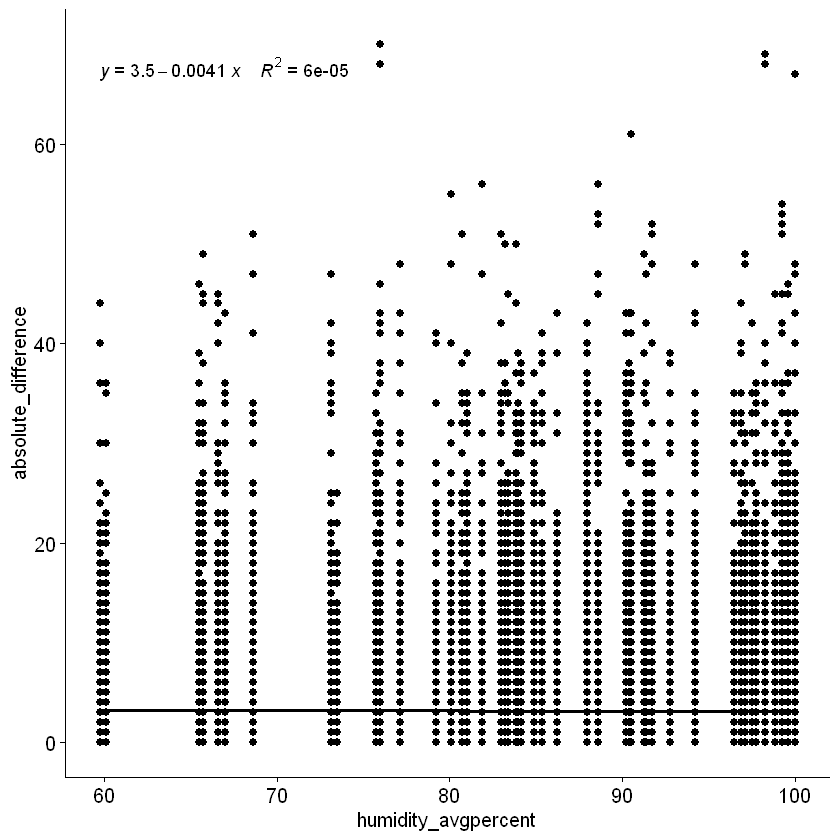

In [19]:
#simple visual of humidity vs abs diff
ggscatter(
  df, x = "humidity_avgpercent", y = "absolute_difference", add = "reg.line"
  )+
  stat_regline_equation(
    aes(label =  paste(..eq.label.., ..rr.label.., sep = "~~~~"))
    )

Warning message:
"`fun.y` is deprecated. Use `fun` instead."


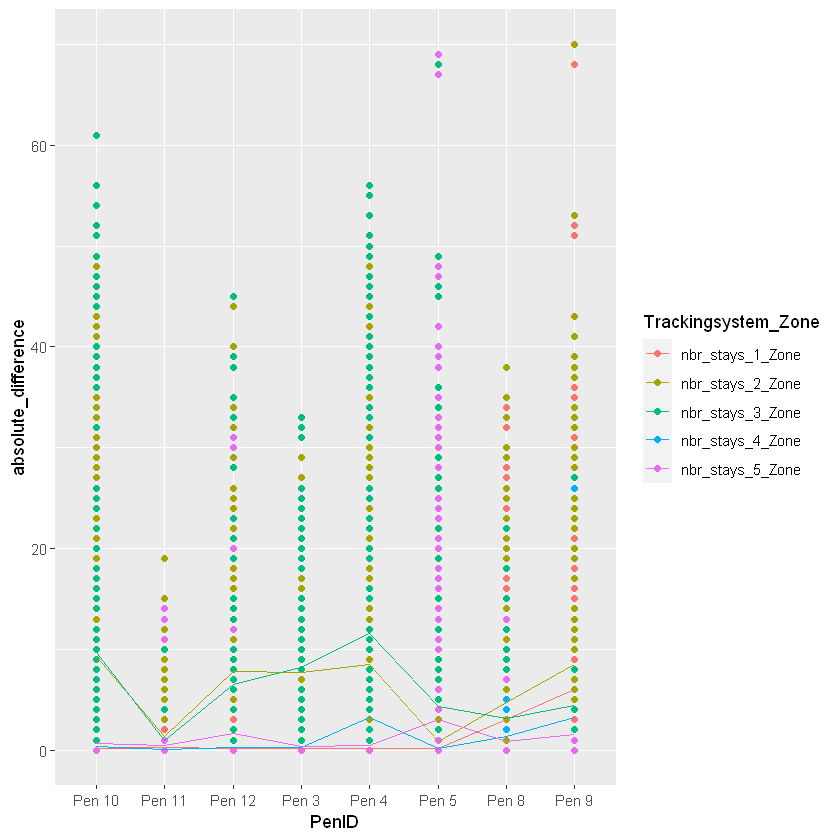

In [56]:
ggplot(df, aes(x = PenID, y = absolute_difference, group = Trackingsystem_Zone, col = Trackingsystem_Zone)) + 
  geom_point() + stat_summary(fun.y = mean, geom = "line")

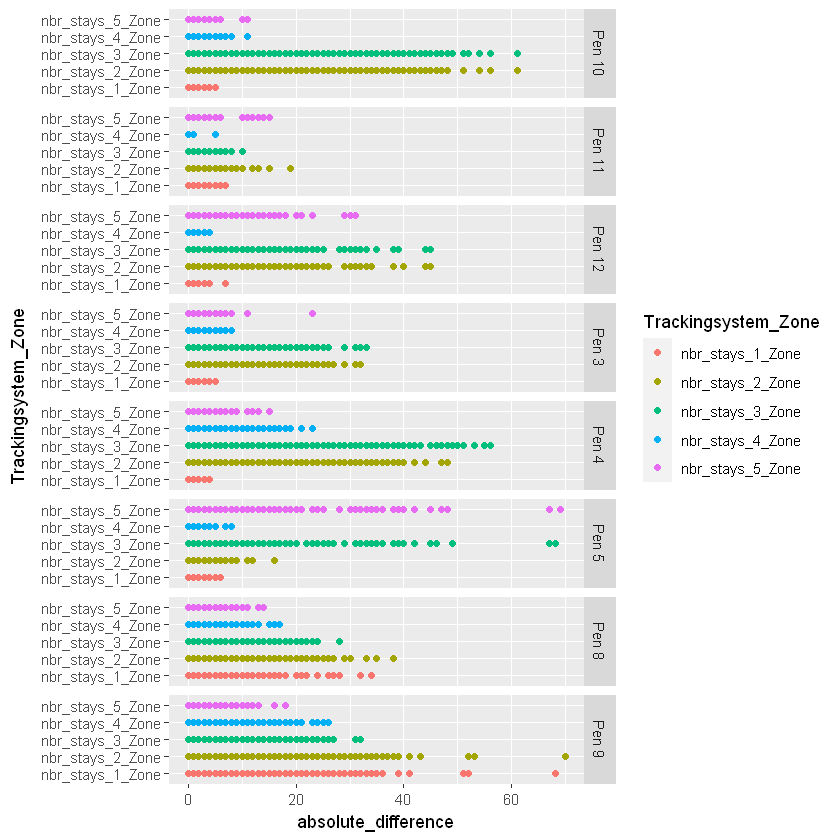

In [19]:
ggplot(df, aes(y = Trackingsystem_Zone, x = absolute_difference, col=Trackingsystem_Zone)) + geom_point() + facet_grid(PenID ~ .)
ggsave(path = path_, width = 9, height = 6, device='tiff', filename='visualisation_basics.jpg', dpi=700)

In [62]:
fit = lmer(absolute_difference ~ PenID + (1|HenID)+(1 | HenID:Trackingsystem_Zone), data = df)
#Hence, this boils down to comparing the variation between different PenID (having 7 degrees of freedom) to the variation 
#due to the interaction between Trackingsystem_Zone and HenID (having  5*159=795  degrees of freedom).
summary(fit)
anova(fit)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
absolute_difference ~ PenID + (1 | HenID) + (1 | HenID:Trackingsystem_Zone)
   Data: df

REML criterion at convergence: 218305.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.6831 -0.2463 -0.0464  0.1138 17.8180 

Random effects:
 Groups                    Name        Variance Std.Dev.
 HenID:Trackingsystem_Zone (Intercept) 19.483   4.414   
 HenID                     (Intercept)  1.694   1.302   
 Residual                              11.389   3.375   
Number of obs: 40735, groups:  HenID:Trackingsystem_Zone, 795; HenID, 159

Fixed effects:
            Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)   4.0321     0.5308 151.0189   7.596 2.97e-12 ***
PenIDPen 11  -3.4114     0.7507 151.0165  -4.544 1.12e-05 ***
PenIDPen 12  -0.7593     0.7605 151.0165  -0.998  0.31969    
PenIDPen 3   -0.7076     0.7507 151.0165  -0.943  0.34738    
PenIDPen 4    0.7467     0.7

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
PenID,593.8722,84.83889,7,151.0032,7.448914,1.088449e-07


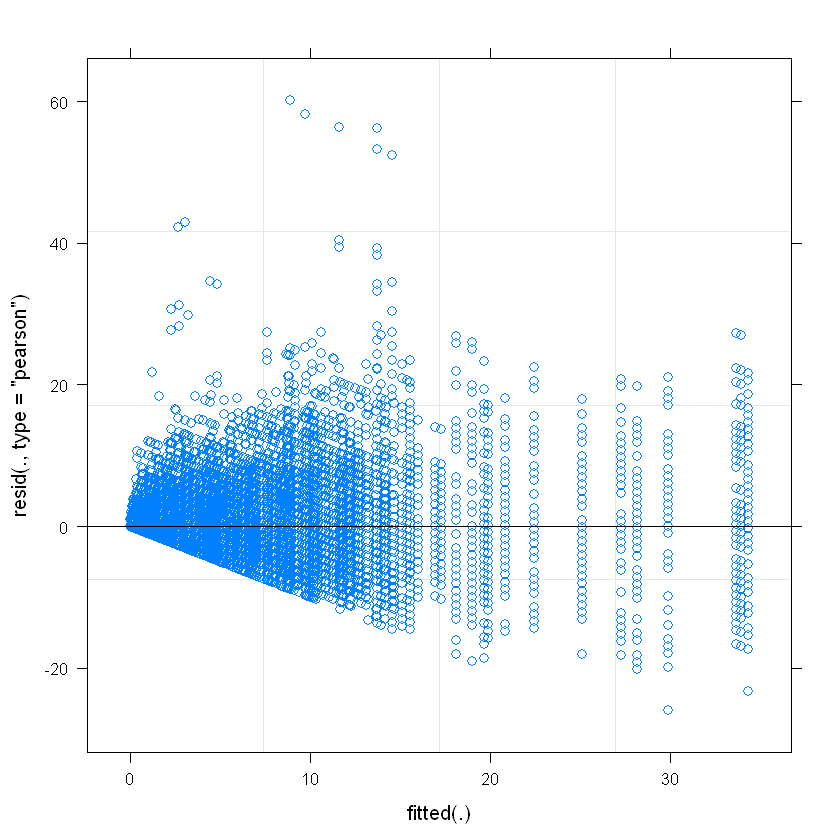

In [63]:
## Tukey-Anscombe plot:
plot(fit)

$`HenID:Trackingsystem_Zone`

$HenID


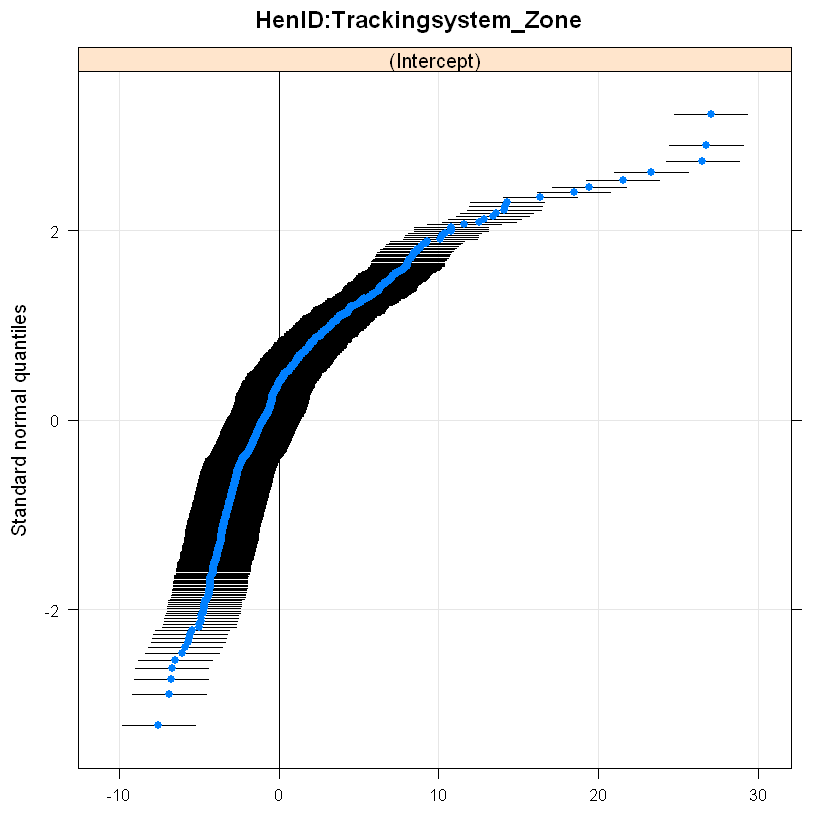

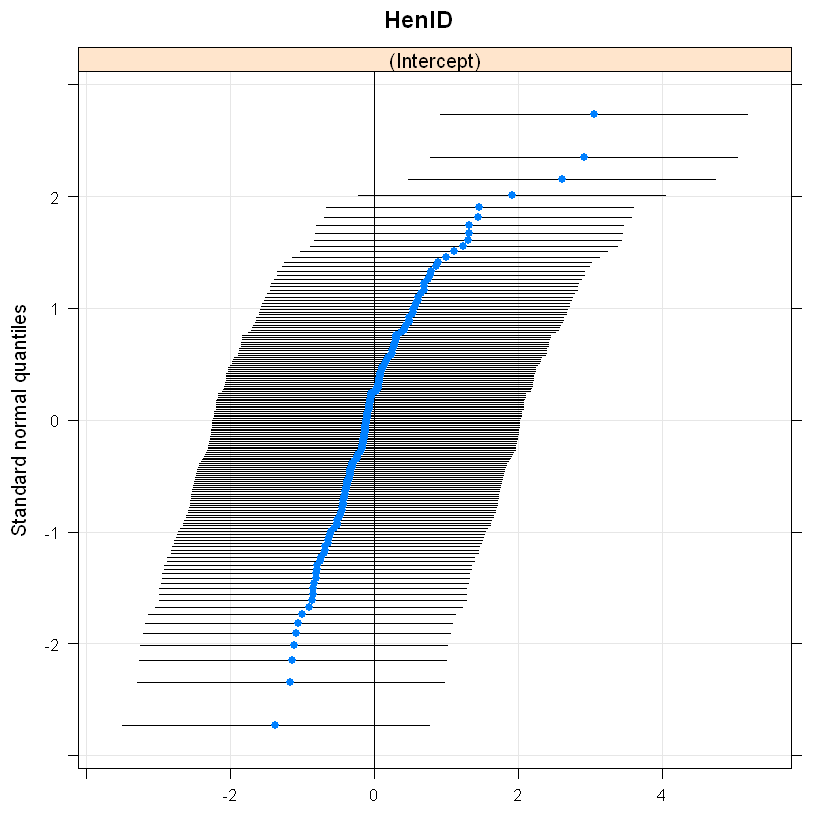

In [65]:
#qqplot
qqmath(ranef(fit))

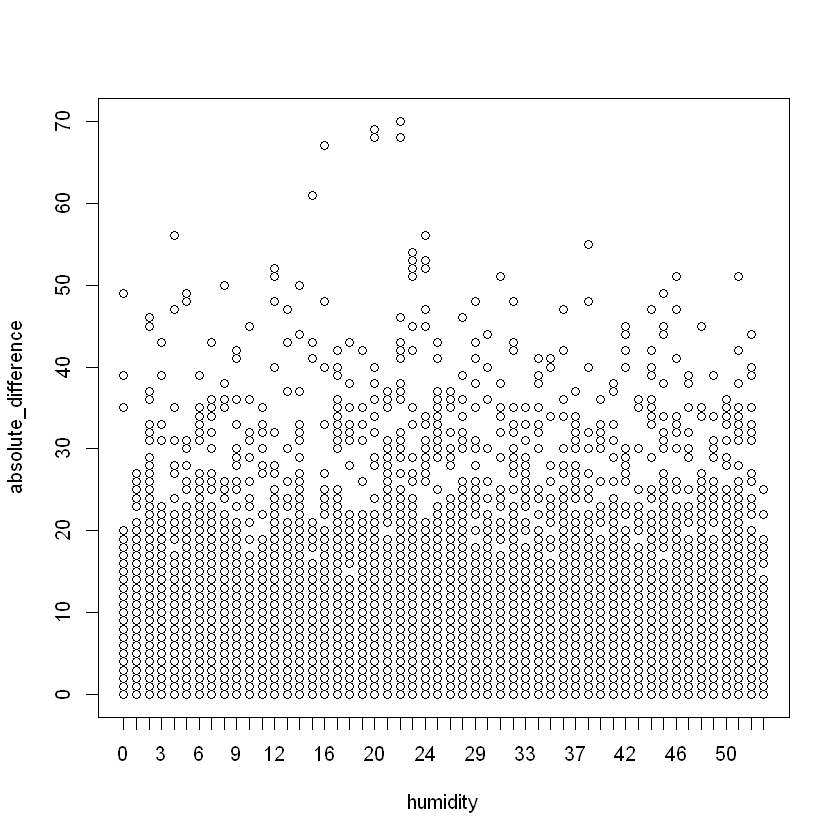

In [44]:
## Visualize data ####
stripchart(absolute_difference ~ level_continuous, vertical = TRUE, pch = 1, xlab = "humidity", data = df)

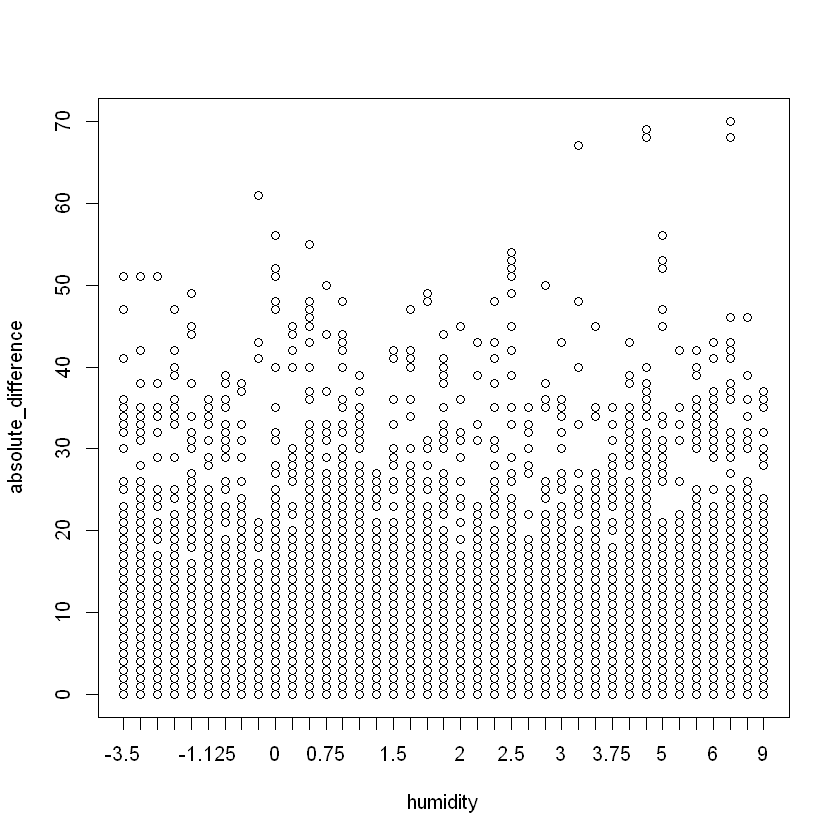

In [47]:
## Visualize data ####
stripchart(absolute_difference ~ temperature_C, vertical = TRUE, pch = 1, xlab = "humidity", data = df)

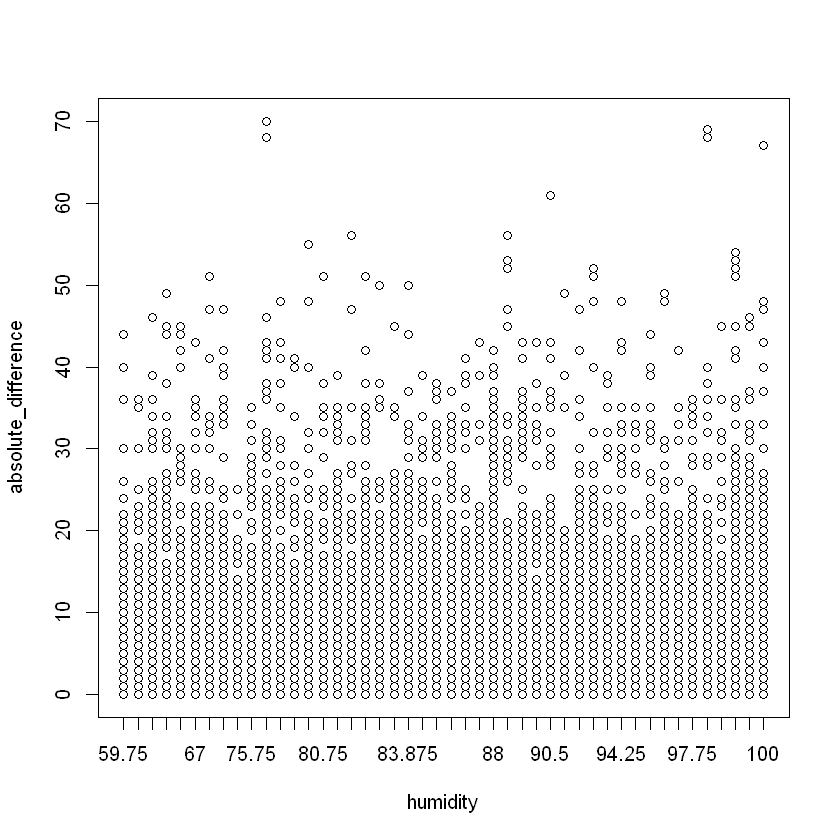

In [43]:
## Visualize data ####
stripchart(absolute_difference ~ humidity_avgpercent, vertical = TRUE, pch = 1, xlab = "humidity", data = df)

# One way ANOVA assumption

### Linearity assumption between covariate and outcome

`geom_smooth()` using formula 'y ~ x'



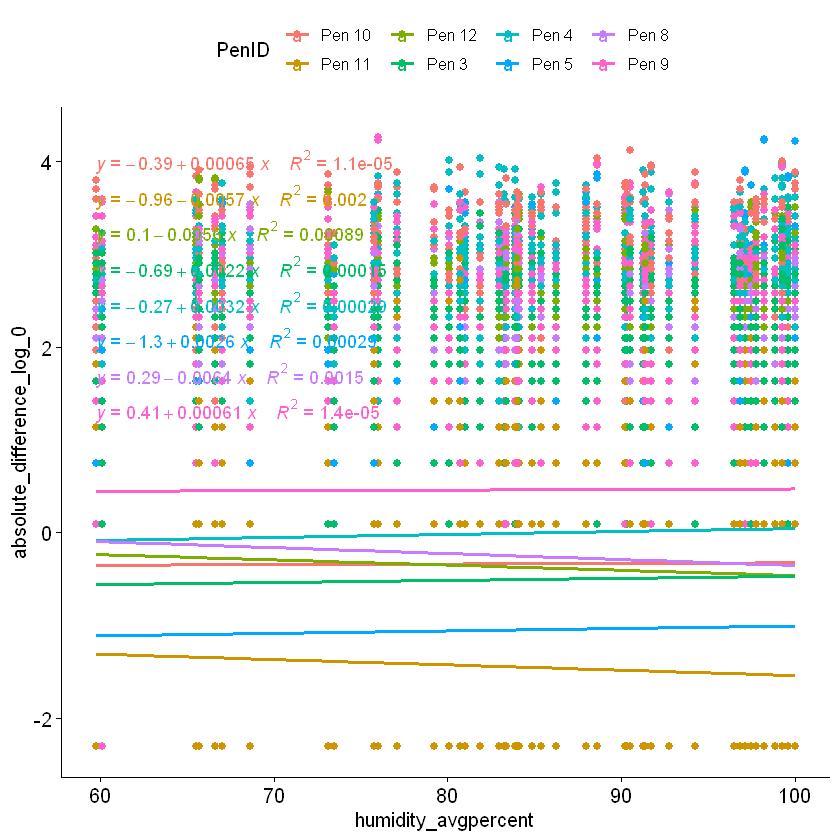

In [24]:
ggscatter(
  df, x = "humidity_avgpercent", y = "absolute_difference_log_0",
  color = "PenID", add = "reg.line"
  )+
  stat_regline_equation(
    aes(label =  paste(..eq.label.., ..rr.label.., sep = "~~~~"), color = PenID)
    )

### Homogeneity of regression slopes

In [25]:
df %>% anova_test(absolute_difference_log_0 ~ PenID*humidity_avgpercent)

Coefficient covariances computed by hccm()



,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,PenID,7,40719,512.395,0.000,*,8.10e-02
2,humidity_avgpercent,1,40719,1.216,0.270,,2.99e-05
3,PenID:humidity_avgpercent,7,40719,2.943,0.004,*,5.06e-04


In [ ]:
model = lm(absolute_difference_log_0~PenID, data=df_z1)
print(summary(model))
af = anova(model)
afss = af$"Sum Sq"
print(cbind(af,PctExp=afss/sum(afss)*100))
lindia::gg_diagnose(model)

In [55]:
model_re = lmer(absolute_difference_log_0 ~ (1 | PenID/Trackingsystem_Zone), data = df)
summary(model_re)

boundary (singular) fit: see ?isSingular



Linear mixed model fit by REML ['lmerMod']
Formula: absolute_difference_log_0 ~ (1 | PenID/Trackingsystem_Zone)
   Data: df

REML criterion at convergence: 142383.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1219 -0.4402 -0.2184  0.7173  3.5746 

Random effects:
 Groups                    Name        Variance  Std.Dev. 
 Trackingsystem_Zone:PenID (Intercept) 1.957e+00 1.399e+00
 PenID                     (Intercept) 7.153e-12 2.675e-06
 Residual                              1.917e+00 1.384e+00
Number of obs: 40735, groups:  Trackingsystem_Zone:PenID, 40; PenID, 8

Fixed effects:
            Estimate Std. Error t value
(Intercept)  -0.4373     0.2213  -1.976
optimizer (nloptwrap) convergence code: 0 (OK)
boundary (singular) fit: see ?isSingular


In [ ]:
#TODO: TOREAD: https://stat.ethz.ch/~meier/teaching/anova/random-and-mixed-effects-models.html

In [41]:
#environemental factors
#date as categories
#date as continuous variable
#total time of ay
#Trackingsystem_Zone
model_re = glmer(absolute_difference_log_0 ~ PenID +(1|level)+(1|HenID)+(1|Trackingsystem_Zone), data = df) 
print(summary(model_re))

Warning message in glmer(absolute_difference_log_0 ~ PenID + (1 | level) + (1 | :
"calling glmer() with family=gaussian (identity link) as a shortcut to lmer() is deprecated; please call lmer() directly"


Linear mixed model fit by REML ['lmerMod']
Formula: absolute_difference_log_0 ~ PenID + (1 | level) + (1 | HenID) +  
    (1 | Trackingsystem_Zone)
   Data: df

REML criterion at convergence: 144792.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.6421 -0.7397 -0.0241  0.7275  4.2321 

Random effects:
 Groups              Name        Variance Std.Dev.
 HenID               (Intercept) 0.43650  0.6607  
 level               (Intercept) 0.01711  0.1308  
 Trackingsystem_Zone (Intercept) 1.33258  1.1544  
 Residual                        2.00828  1.4171  
Number of obs: 40735, groups:  HenID, 159; level, 52; Trackingsystem_Zone, 5

Fixed effects:
            Estimate Std. Error t value
(Intercept) -0.32980    0.53765  -0.613
PenIDPen 11 -1.12337    0.21080  -5.329
PenIDPen 12 -0.04905    0.21356  -0.230
PenIDPen 3  -0.17010    0.21081  -0.807
PenIDPen 4   0.32976    0.21081   1.564
PenIDPen 5  -0.71061    0.21081  -3.371
PenIDPen 8   0.07237    0.21079   0.343
PenIDPen 9  

In [42]:
af = anova(model_re)
afss = af$"Sum Sq"
print(cbind(af,PctExp=afss/sum(afss)*100))

      npar   Sum Sq  Mean Sq  F value PctExp
PenID    7 221.4605 31.63721 15.75341    100


In [50]:
#random slopes as well
model_re = glmer(absolute_difference_log_0 ~ PenID +(absolute_difference_log_0|level)+(1|HenID)+(absolute_difference_log_0|Trackingsystem_Zone), data = df) 
summary(model_re)

Warning message in glmer(absolute_difference_log_0 ~ PenID + (absolute_difference_log_0 | :
"calling glmer() with family=gaussian (identity link) as a shortcut to lmer() is deprecated; please call lmer() directly"
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"unable to evaluate scaled gradient"
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge: degenerate  Hessian with 1 negative eigenvalues"


Linear mixed model fit by REML ['lmerMod']
Formula: absolute_difference_log_0 ~ PenID + (absolute_difference_log_0 |  
    level) + (1 | HenID) + (absolute_difference_log_0 | Trackingsystem_Zone)
   Data: df

REML criterion at convergence: -1111609

Scaled residuals: 
       Min         1Q     Median         3Q        Max 
-2.181e-05 -4.265e-06  5.916e-07  4.849e-06  1.740e-05 

Random effects:
 Groups              Name                      Variance  Std.Dev.  Corr 
 HenID               (Intercept)               4.639e-15 6.811e-08      
 level               (Intercept)               6.865e-10 2.620e-05      
                     absolute_difference_log_0 5.605e-05 7.487e-03 -1.00
 Trackingsystem_Zone (Intercept)               9.538e-09 9.766e-05      
                     absolute_difference_log_0 1.177e-04 1.085e-02 -0.02
 Residual                                      7.692e-14 2.774e-07      
Number of obs: 40735, groups:  HenID, 159; level, 52; Trackingsystem_Zone, 5

Fixed effects

In [ ]:
confint(model_re, oldNames = FALSE)

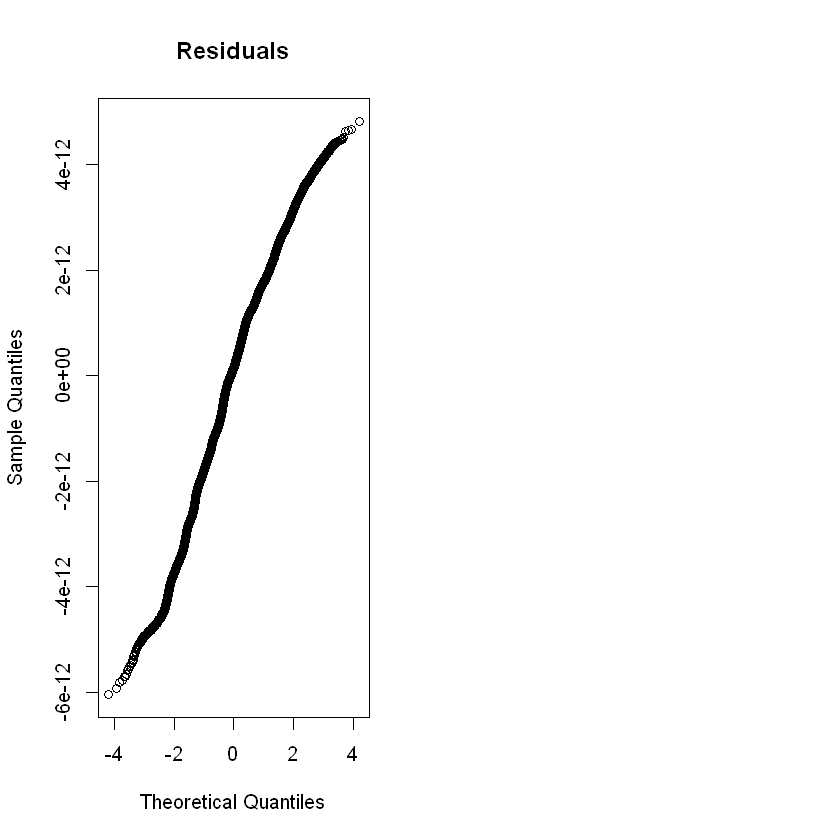

In [51]:
par(mfrow = c(1, 2))
qqnorm(resid(model_re), main = "Residuals")

In [ ]:
lindia::gg_diagnose(model_re)

# One-way ANOVA